# Проверка гипотез

При визуализации у вас возникли гипотезы о закономерностях, которые есть в ваших данных. Проверьте эти гипотезы с помощью математической статистики. Итоговый балл зависит от того, насколько интересные находки вы сделаете и насколько корректно вы подберёте для проверки критерий/процедуру. Это может быть что угодно от непараметрических тестов и z-статистики до бутстрапа и теста отношения правдоподобий.

In [62]:
import pandas as pd
import numpy as np
import scipy.stats as sts
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, bartlett, ttest_ind, shapiro, ks_2samp, ttest_1samp, chi2_contingency, ttest_rel
from collections import defaultdict

In [63]:
data = pd.read_csv('https://raw.githubusercontent.com/AleksKids/hedonistic-demand-from-ebay/main/Preprocessing/Great_BD.tsv', delimiter = "\t")
data.head()

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,OTG,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging,WAP,WCDMA,Last_Sale,Is_Target
0,Apple iPhone 11 64GB Factory Unlocked 4G LTE S...,337.59,0.00,19787.0,6679958.00,https://www.ebay.com/itm/254604777645?nordt=tr...,Very Good - Refurbished,“This iPhone 11 is in Very Good condition and ...,apple,iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
1,Apple iPhone XR 64GB Factory Unlocked Smartpho...,266.28,0.00,12440.0,3312560.60,https://www.ebay.com/itm/254187678666?nordt=tr...,Very Good - Refurbished,“This Apple iPhone XR 64GB Factory Unlocked Sm...,apple,iPhone XR,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
2,Apple iPhone 11 64GB Unlocked Smartphone - Ver...,359.11,16.93,12224.0,4389742.37,https://www.ebay.com/itm/363183815277?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3,Apple iPhone X 64GB Factory Unlocked Phone - V...,231.98,16.50,11781.0,2732899.88,https://www.ebay.com/itm/382605209867?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,1.0,1,1.0,1,1,1.0,1,1,2023-06-14 00:00:00,0
4,Apple iPhone X 256GB Unlocked Smartphone - Ver...,263.59,15.34,10020.0,2641203.85,https://www.ebay.com/itm/382446518910?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0


,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,OTG,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging,WAP,WCDMA,Last_Sale,Is_Target
0,Apple iPhone 11 64GB Factory Unlocked 4G LTE S...,337.59,0.00,19787.0,6679958.00,https://www.ebay.com/itm/254604777645?nordt=tr...,Very Good - Refurbished,“This iPhone 11 is in Very Good condition and ...,apple,iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
1,Apple iPhone XR 64GB Factory Unlocked Smartpho...,266.28,0.00,12440.0,3312560.60,https://www.ebay.com/itm/254187678666?nordt=tr...,Very Good - Refurbished,“This Apple iPhone XR 64GB Factory Unlocked Sm...,apple,iPhone XR,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
2,Apple iPhone 11 64GB Unlocked Smartphone - Ver...,359.11,16.93,12224.0,4389742.37,https://www.ebay.com/itm/363183815277?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3,Apple iPhone X 64GB Factory Unlocked Phone - V...,231.98,16.50,11781.0,2732899.88,https://www.ebay.com/itm/382605209867?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,1.0,1,1.0,1,1,1.0,1,1,2023-06-14 00:00:00,0
4,Apple iPhone X 256GB Unlocked Smartphone - Ver...,263.59,15.34,10020.0,2641203.85,https://www.ebay.com/itm/382446518910?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0


## Проверка гипотезы о лог-нормальности распределения цен

Далее мы рассматриваем выборку из независимых случайных величин, таких как цены смартфонов. Естественно, стоимость начинается с 0 ("покупаю за бесплатно!"). Цена представлена в долларах за один гаджет.

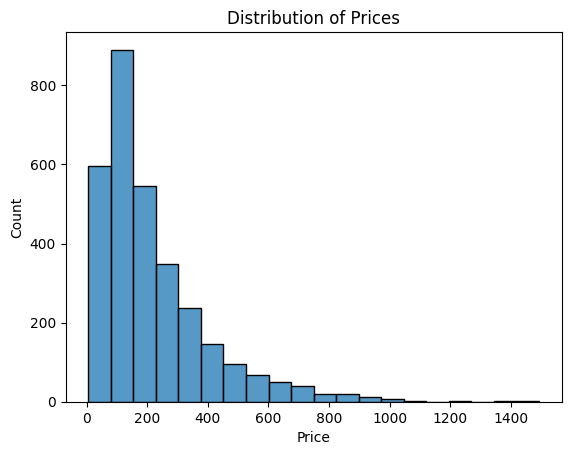

In [64]:
# Гистограмма распределения цен
sns.histplot(data[data.Is_Target==0]['Price'], bins=20)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Визуально распределение цен напомнило нам логнормальное распределение, поэтому далее мы захотели проверить нашу гипотезу.

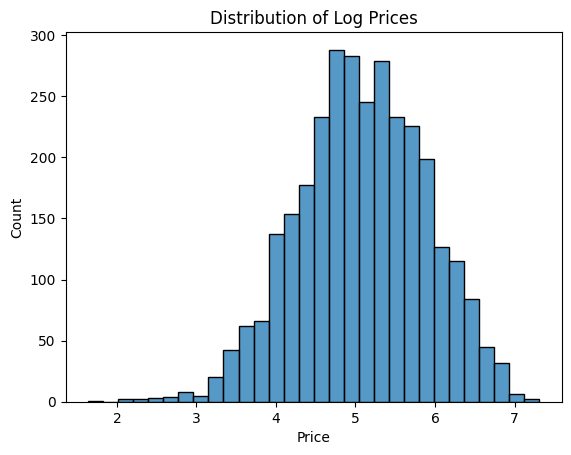

In [65]:
# Гистограмма распределения логарифма цен
sns.histplot(np.log(data[data.Is_Target==0]['Price']), bins=30)
plt.title('Distribution of Log Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

На гистограмме изображено распределение логарифма цен, и вот оно как раз совсем напоминает нормальное (визуально с мат.ожиданием 5 и стандартным отклонением 0,5)

Для проверки нормальности распределения данных можно использовать различные статистические тесты. Некоторые из наиболее распространенных тестов включают в себя:

Критерий Шапиро-Уилка (Shapiro-Wilk test): Этот тест проверяет гипотезу о нормальности распределения. Он вычисляет статистику W и выдает соответствующее p-значение. Если p-значение меньше заданного уровня значимости, то гипотеза о нормальности отвергается.

Колмогорова-Смирнова тест (Kolmogorov-Smirnov test): Этот тест используется для сравнения эмпирической функции распределения с теоретической функцией распределения. Он вычисляет статистику Колмогорова-Смирнова и p-значение. Если p-значение меньше заданного уровня значимости, то гипотеза о нормальности отвергается.

Андерсона-Дарлинга тест (Anderson-Darling test): Этот тест также основан на сравнении эмпирической функции распределения с теоретической функцией распределения, но в отличие от Колмогорова-Смирнова теста, он накладывает больший учет на значения, находящиеся в хвостах распределения. Он вычисляет статистику Андерсона-Дарлинга и p-значение, и если p-значение меньше заданного уровня значимости, то гипотеза о нормальности отвергается.

In [14]:
price_data = data[data['Is_Target'] == 0]['Price']

# Критерий Шапиро-Уилка
shapiro_test = sts.shapiro(price_data)
print('Shapiro-Wilk test:')
print('Test statistic:', shapiro_test.statistic)
print('p-value:', shapiro_test.pvalue)

# Колмогорова-Смирнова тест
kstest = sts.kstest(price_data, 'norm')
print('\nKolmogorov-Smirnov test:')
print('Test statistic:', kstest.statistic)
print('p-value:', kstest.pvalue)

# Андерсона-Дарлинга тест
anderson_test = sts.anderson(price_data, dist='norm')
print('\nAnderson-Darling test:')
print('Test statistic:', anderson_test.statistic)
print('Critical values:', anderson_test.critical_values)
print('Significance levels:', anderson_test.significance_level)

Shapiro-Wilk test:
Test statistic: 0.8259972929954529
p-value: 0.0

Kolmogorov-Smirnov test:
Test statistic: 0.9999998697567705
p-value: 0.0

Anderson-Darling test:
Test statistic: 146.063810053844
Critical values: [0.575 0.655 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]


In [67]:
price_data = np.log(data[data['Is_Target'] == 0]['Price'])

# Критерий Шапиро-Уилка
shapiro_test = sts.shapiro(price_data)
print('Shapiro-Wilk test:')
print('Test statistic:', shapiro_test.statistic)
print('p-value:', shapiro_test.pvalue)

# Колмогорова-Смирнова тест
kstest = sts.kstest(price_data, 'norm')
print('\nKolmogorov-Smirnov test:')
print('Test statistic:', kstest.statistic)
print('p-value:', kstest.pvalue)

# Андерсона-Дарлинга тест
anderson_test = sts.anderson(price_data, dist='norm')
print('\nAnderson-Darling test:')
print('Test statistic:', anderson_test.statistic)
print('Critical values:', anderson_test.critical_values)
print('Significance levels:', anderson_test.significance_level)

Shapiro-Wilk test:
Test statistic: 0.9964608550071716
p-value: 1.202107796416385e-06

Kolmogorov-Smirnov test:
Test statistic: 0.9936527696884732
p-value: 0.0

Anderson-Darling test:
Test statistic: 1.1827941891442606
Critical values: [0.575 0.655 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]


Итого, проведя 'эти тесты, мы можем отвергнуть гипотезу о том, что логарифмы цен имеют нормальное распределение, а значит, можем отвергнуть гипотезу о логнормальном распределении цен на смартфоны. Что весьма парадоксально. Вероятно, это вызвано высокой чувствительностью теста.

## Проверка однородности распределений для Nokia и Redmi

Для проверки одинаковости распределений двух случайных величин можно использовать различные статистические тесты. Некоторые из наиболее распространенных тестов включают в себя:

Тест Вилкоксона-Манна-Уитни (Wilcoxon-Mann-Whitney test): Этот тест используется для сравнения двух выборок независимых наблюдений. Он вычисляет статистику Уилкоксона-Манна-Уитни и p-значение. Если p-значение больше заданного уровня значимости, то гипотеза о равенстве распределений не отвергается.

Тест Колмогорова-Смирнова двухвыборочный (Two-sample Kolmogorov-Smirnov test): Этот тест также используется для сравнения двух выборок. Он вычисляет статистику Колмогорова-Смирнова и p-значение. Если p-значение больше заданного уровня значимости, то гипотеза о равенстве распределений не отвергается.

In [50]:
nokia = data[(data['Is_Target'] == 1) & (data['Brand'] == 'nokia')]['Price']
redmi = data[(data['Is_Target'] == 1) & (data['Brand'] == 'redmi')]['Price']

# Тест Вилкоксона-Манна-Уитни
mannwhitneyu_test = sts.mannwhitneyu(nokia, redmi)
print('\nWilcoxon-Mann-Whitney test:')
print('Test statistic:', mannwhitneyu_test.statistic)
print('p-value:', mannwhitneyu_test.pvalue)

# Тест Колмогорова-Смирнова двухвыборочный
two_sample_ks_test = sts.ks_2samp(nokia, redmi)
print('\nTwo-sample Kolmogorov-Smirnov test:')
print('Test statistic:', two_sample_ks_test.statistic)
print('p-value:', two_sample_ks_test.pvalue)


Wilcoxon-Mann-Whitney test:
Test statistic: 421772.5
p-value: 1.601723360301852e-294

Two-sample Kolmogorov-Smirnov test:
Test statistic: 0.6476774698303019
p-value: 1.0591172570416635e-293


In [51]:
nokia = np.log(data[(data['Is_Target'] == 1) & (data['Brand'] == 'nokia')]['Price'])
redmi = np.log(data[(data['Is_Target'] == 1) & (data['Brand'] == 'redmi')]['Price'])

# Тест Вилкоксона-Манна-Уитни
mannwhitneyu_test = sts.mannwhitneyu(nokia, redmi)
print('\nWilcoxon-Mann-Whitney test:')
print('Test statistic:', mannwhitneyu_test.statistic)
print('p-value:', mannwhitneyu_test.pvalue)

# Тест Колмогорова-Смирнова двухвыборочный
two_sample_ks_test = sts.ks_2samp(nokia, redmi)
print('\nTwo-sample Kolmogorov-Smirnov test:')
print('Test statistic:', two_sample_ks_test.statistic)
print('p-value:', two_sample_ks_test.pvalue)


Wilcoxon-Mann-Whitney test:
Test statistic: 421772.5
p-value: 1.601723360301852e-294

Two-sample Kolmogorov-Smirnov test:
Test statistic: 0.6476774698303019
p-value: 1.0591172570416635e-293


## Проверка корреляции

### Цена и количество продаж

In [52]:
# Вычисление коэффициента корреляции Пирсона и p-значения
correlation, p_value = sts.pearsonr(data[data.Is_Target==0]['Price'], data[data.Is_Target==0]["Sales_Count"])

# Вывод результатов
print("Коэффициент корреляции Пирсона:", correlation)
print("p-значение:", p_value)

Коэффициент корреляции Пирсона: -0.009647133392949456
p-значение: 0.5925189639939266


### Цена и количество фичей

In [59]:
features = data[data.Is_Target==0][['2G', '3G', '4G', '5G', 'Bluetooth', 'GSM',
       'WI-FI', 'Micro USB', 'USB', 'Type-C', 'Fast_usb', 'NFC', 'Dual-Band',
       'ANT+', 'Android Beam', 'Beidou', 'Cellular', 'FM', 'DLNA', 'EDGE',
       'Fast Charge', 'GPS', 'Galileo', 'Global Version', 'HDMI Micro',
       'Glonass', 'Headphone Jack', 'OTA', 'OTG', 'Infrared', 'Lightning',
       'Quad-Band', 'Tri-Band', 'Wireless charging', 'WAP', 'WCDMA',
       'Last_Sale']]
features_sum = features.sum(axis=1)
price = data[data.Is_Target==0].Price

# Вычисление коэффициента корреляции Пирсона и p-значения
correlation, p_value = sts.pearsonr(features_sum, price)

# Вывод результатов
print("Коэффициент корреляции Пирсона:", correlation)
print("p-значение:", p_value)

Коэффициент корреляции Пирсона: -0.031828557545070205
p-значение: 0.07737174702365003


C:\Users\druny\AppData\Local\Temp\ipykernel_19988\2329668319.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_sum = features.sum(axis=1)


In [58]:
data[data.Is_Target==0][["Price", '2G', '3G', '4G', '5G', 'Bluetooth', 'GSM',
       'WI-FI', 'Micro USB', 'USB', 'Type-C', 'Fast_usb', 'NFC', 'Dual-Band',
       'ANT+', 'Android Beam', 'Beidou', 'Cellular', 'FM', 'DLNA', 'EDGE',
       'Fast Charge', 'GPS', 'Galileo', 'Global Version', 'HDMI Micro',
       'Glonass', 'Headphone Jack', 'OTA', 'OTG', 'Infrared', 'Lightning',
       'Quad-Band', 'Tri-Band', 'Wireless charging', 'WAP', 'WCDMA',
       'Last_Sale']].corr()["Price"]

C:\Users\druny\AppData\Local\Temp\ipykernel_19988\3389409334.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Last_Sale']].corr()["Price"]


Price                1.000000
2G                  -0.119060
3G                  -0.149001
4G                  -0.050196
5G                   0.228307
Bluetooth            0.154572
GSM                 -0.060058
WI-FI                0.114249
Micro USB           -0.103529
USB                 -0.067013
Type-C              -0.053815
Fast_usb            -0.059493
NFC                  0.207656
Dual-Band           -0.055960
ANT+                -0.061359
Android Beam        -0.060661
Beidou              -0.059076
Cellular            -0.056110
FM                  -0.059270
DLNA                -0.061265
EDGE                -0.059384
Fast Charge         -0.059384
GPS                 -0.023290
Galileo             -0.059384
Global Version      -0.059270
HDMI Micro          -0.059914
Glonass             -0.059076
Headphone Jack      -0.059602
OTA                 -0.059270
OTG                 -0.059270
Infrared            -0.059529
Lightning            0.192643
Quad-Band           -0.063047
Tri-Band  

### Объём продаж и количество фичей

In [57]:
features = data[data.Is_Target==0][['2G', '3G', '4G', '5G', 'Bluetooth', 'GSM',
       'WI-FI', 'Micro USB', 'USB', 'Type-C', 'Fast_usb', 'NFC', 'Dual-Band',
       'ANT+', 'Android Beam', 'Beidou', 'Cellular', 'FM', 'DLNA', 'EDGE',
       'Fast Charge', 'GPS', 'Galileo', 'Global Version', 'HDMI Micro',
       'Glonass', 'Headphone Jack', 'OTA', 'OTG', 'Infrared', 'Lightning',
       'Quad-Band', 'Tri-Band', 'Wireless charging', 'WAP', 'WCDMA',
       'Last_Sale']]
features_sum = features.sum(axis=1)
Sales_Count = data[data.Is_Target==0].Sales_Count

# Вычисление коэффициента корреляции Пирсона и p-значения
correlation, p_value = sts.pearsonr(features_sum, Sales_Count)

# Вывод результатов
print("Коэффициент корреляции Пирсона:", correlation)
print("p-значение:", p_value)

Коэффициент корреляции Пирсона: 0.010438646241466775
p-значение: 0.5625203683005744


C:\Users\druny\AppData\Local\Temp\ipykernel_19988\2655371639.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_sum = features.sum(axis=1)


In [56]:
data[data.Is_Target==0][["Sales_Count", '2G', '3G', '4G', '5G', 'Bluetooth', 'GSM',
       'WI-FI', 'Micro USB', 'USB', 'Type-C', 'Fast_usb', 'NFC', 'Dual-Band',
       'ANT+', 'Android Beam', 'Beidou', 'Cellular', 'FM', 'DLNA', 'EDGE',
       'Fast Charge', 'GPS', 'Galileo', 'Global Version', 'HDMI Micro',
       'Glonass', 'Headphone Jack', 'OTA', 'OTG', 'Infrared', 'Lightning',
       'Quad-Band', 'Tri-Band', 'Wireless charging', 'WAP', 'WCDMA',
       'Last_Sale', 'Is_Target']].corr()["Sales_Count"]

C:\Users\druny\AppData\Local\Temp\ipykernel_19988\1888951886.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Last_Sale', 'Is_Target']].corr()["Sales_Count"]


Sales_Count          1.000000
2G                  -0.001752
3G                  -0.011142
4G                  -0.010631
5G                  -0.013597
Bluetooth           -0.030858
GSM                  0.020177
WI-FI               -0.049602
Micro USB            0.011388
USB                  0.019569
Type-C              -0.007059
Fast_usb             0.020022
NFC                 -0.038702
Dual-Band            0.019397
ANT+                 0.020965
Android Beam         0.020079
Beidou               0.019728
Cellular             0.024870
FM                   0.020100
DLNA                 0.019844
EDGE                 0.020321
Fast Charge          0.020321
GPS                  0.020077
Galileo              0.020321
Global Version       0.020100
HDMI Micro           0.020270
Glonass              0.019728
Headphone Jack       0.020105
OTA                  0.020100
OTG                  0.020100
Infrared             0.020057
Lightning           -0.015264
Quad-Band            0.019335
Tri-Band  